# Preprocess WaPOR data using python

This notebook contains step to preprocess WaPOR data
- [1. Crop to Extent](#1.-Crop-to-Extent)
- [2. Rescale using metadata](#2.-Rescale-using-metadata)
- [3. Aggregate monthly data](#3.-Aggregate-monthly-data)
- [4. Aggregate data in a period](#4.-Aggregate-data-in-a-period)
- [5. Warp raster data](#5.-Warp-raster-data)
- [6. Clip to Shapefile cutline](#6.-Clip-to-Shapefile-cutline)

First, import libraries/packages

In [1]:
import os
import shapefile
import glob
import gdal
import osgeo
import hkvwaporpy as hkv
import osr
import ogr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

## Step 1. Crop to Extent
### Example
To crop raster mapset to a region of interest, a shapefile or the extent coordinate of the ROI is needed.
For example, a shapefile of Awash Basin has been prepared. The code below shows how to get the exent of Awash Basin.First, read the bbox of the given shapefile of the Region of interest.

In [2]:
tg_shp= r".\data\Awash_shapefile.shp"
shape = shapefile.Reader(tg_shp)
shape.bbox

[37.95883206252312, 7.89534, 43.32093, 12.3873979377346]

In [3]:
extent=shape.bbox
xmin,ymin,xmax,ymax=extent[0],extent[1],extent[2],extent[3]
xmin,ymin,xmax,ymax

(37.95883206252312, 7.89534, 43.32093, 12.3873979377346)

To get a list of all raster handlers in the folder to be cropped, we can use package *glob* as following.

In [4]:
input_folder=r'.\data\L1_PCP_E'
input_fhs=glob.glob(input_folder+'\*.tif')
print('Number of files: {0}'.format(len(input_fhs)))

Number of files: 730


The *gdal.Translate* function can be used to quickly crop a raster file to a given extent. 
Below is an example to crop a raster file in the obtained list of raster handlers. First, the input and output file handlers are defined. Then *translate_options* object is created using coordinates of the window to crop.

In [5]:
output_folder=r'.\data\L1_PCP_E_cropped'
if not os.path.exists(output_folder): #check if output_folder is created
    os.makedirs(output_folder) #create output_folder
in_fh=input_fhs[0] #get the path of the first file in input_fhs list
print('in_fh: '+in_fh) #print the input file path

in_fh: .\data\L1_PCP_E\L1_PCP_090101.tif


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000023D45BA0EA0> >

In [ ]:
input_filename=os.path.split(in_fh)[-1] #get input filename from input path
out_fh=os.path.join(output_folder,input_filename) #create output path string from the input file name

translate_options=gdal.TranslateOptions(format='GTiff',
                                        outputType=osgeo.gdalconst.GDT_Float32,
                                        projWin=[xmin,ymax,xmax,ymin]
                                       )
gdal.Translate(out_fh,in_fh,
               options=translate_options)

### Exercise 1
Crop all the downloaded L1_PCP_E raster data (continent extent) to the extent of Awash Basin.

**Hint**: 

You can use a for-loop.  

**for** file **in** list_of_files:
    
    functions to crop file   

In [ ]:
for in_fh in input_fhs:
    """
    Write your code here
    """
    

In [ ]:
input_folder=r'.\data\L1_PCP_E'
input_fhs=glob.glob(input_folder+'\*.tif')
output_folder=r'.\data\L1_PCP_E_cropped'
if not os.path.exists(output_folder): #check if output_folder is created
    os.makedirs(output_folder) #create output_folder

for in_fh in input_fhs:
    input_filename=os.path.split(in_fh)[-1] #get input filename from input path
    out_fh=os.path.join(output_folder,input_filename) #create output path string from the input file name

    translate_options=gdal.TranslateOptions(format='GTiff',
                                            outputType=osgeo.gdalconst.GDT_Float32,
                                            projWin=[xmin,ymax,xmax,ymin]
                                           )
    gdal.Translate(out_fh,in_fh,
                   options=translate_options)

## Step 2. Rescale using metadata
### Example
The metadata of a dataset contains information about the data such as what is measured, in which unit it is measured, and what is stored in the value. Very often, data is stored in integer *int* format to reduce memory storage space. Thus, to analyze the data as if it is physical values, the stored value must be rescaled, in other words, multiplied with a conversion factor or *multiplier*. For example, the code below is used to get the multiplier of WaPOR Precipitation dataset **L2_AETI_D** and Net Primary Production dataset *L2_NPP_D*. Notice that the multiplier can be different for different dataset.

In [8]:
df=hkv.read_wapor.get_catalogus(version='2.0')

ds_code='L2_NPP_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]
print(ds_code+' multiplier: {0}'.format(multiplier))

ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]
print(ds_code+' multiplier: {0}'.format(multiplier))

L2_NPP_D multiplier: 0.001
L2_AETI_D multiplier: 0.1


To multiply the raw data with a multiplier, you can open the mapset as a numerical array and do calculation with this array. The *gdal* package contains functions to work with raster mapset that can be used to do this task. A raster file has many properties including size, nodata value, transform, spatial reference, projection, etc. These information are stored in the dataset and can be read with *gdal* package. Below is the code to get these information from a GeoTIFF file. 

In [9]:
input_folder=r'.\data\L2_AETI_D'
input_fhs=glob.glob(input_folder+'\*.tif')

in_fh=input_fhs[0]
print(in_fh)

DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)

Type = DataSet.GetDriver().ShortName
bandnumber=1
Subdataset = DataSet.GetRasterBand(bandnumber)
NDV = Subdataset.GetNoDataValue()
xsize = DataSet.RasterXSize
ysize = DataSet.RasterYSize
GeoT = DataSet.GetGeoTransform()
Projection = osr.SpatialReference()
Projection.ImportFromWkt(DataSet.GetProjectionRef())
driver = gdal.GetDriverByName(Type)

print('driver: {0} \nNDV: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}'.format(
    driver, NDV, xsize, ysize, GeoT, Projection))

.\data\L2_AETI_D\L2_AETI_0901.tif
driver: <osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x0000023D4F1F01E0> > 
NDV: -9999.0
xsize: 5406
ysize: 4529
GeoT: (37.957837282836, 0.000992063492, 0.0, 12.3883928732, 0.0, -0.000992063492)
Projection: GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


The data in *gdal* dataset can be read using *ReadAsArray* function. For example, the below code is used to read the opened GeoTIFF dataset as a numpy array. 
You can plot the data in this array using function in *matplotlib* library. Look at the example code and the output plot below. Notice where high EvapoTranspiration occurs. Keep in mind that this is the raw data which show the average daily AETI in a dekad. Thus, the value in the color bar will be corrected with a multiplier and number of days in the next step.

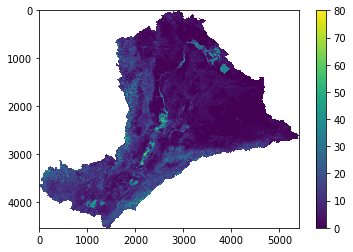

In [10]:
Array = Subdataset.ReadAsArray().astype(np.float32)
Array[Array == NDV] = np.nan

plt.imshow(Array)
plt.colorbar()
plt.show()

Normally, a dekad has 10 days except for the last dekad of the month. For example, the last dekad of February can have 8 or 9 days, and the last dekad of January has 11 days. The number of days in the raster period can be calculated when the starting and ending date is known. Recall that in the previous exercise, we can get this information using hkvwaporpy package's function *get_data_availaility*. Below you can see that each raster_id has a starting and ending day.

In [11]:
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')
df_avail.head()

data_avail_period: DEKAD


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L2_AETI_0901,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0111,0120,L2_AETI_0902,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0121,0131,L2_AETI_0903,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0201,0210,L2_AETI_0904,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0211,0220,L2_AETI_0905,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."


We can access this information and use it to calculate the number of days in the raster period. Below is the example of how to get the number of days in the first raster period in the available data list *df_avail*. You can try to modify the code to do the same calculation for other raster periods.

In [12]:
raster_id=os.path.split(in_fh)[-1].split('.')[0]
print(raster_id)
raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
raster_info

L2_AETI_0901


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L2_AETI_0901,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."


Calculate number of days in dekad of the raster.

In [13]:
start=int(raster_info['start_dekad'].iloc[0])
end=int(raster_info['end_dekad'].iloc[0])
ndays=end-start+1
ndays

10

Once we have the information of conversion factor *multiplier* and number of days *ndays*, we can correct the raw data in raster mapset by multiplying the opened array with these two values. See example below.

multiplier: 0.1
number of days: 10


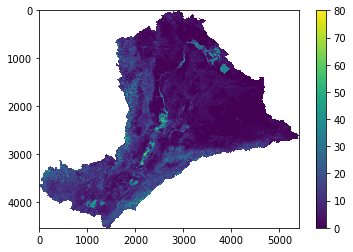

In [14]:
print('multiplier: {0}'.format(multiplier))
print('number of days: {0}'.format(ndays))
CorrectedArray=Array*multiplier*ndays
plt.imshow(CorrectedArray)
plt.colorbar()
plt.show()

To save our result as a raster file (GeoTIFF), we need to know the properties of the original raster file (driver, Nodata Value, size, extent, projection). Below is the example to save the above corrected array as a new raster file.

In [15]:
output_folder=r'.\data\L2_AETI_D_corrected'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
out_fh=os.path.join(output_folder,raster_id+'.tif')

datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
"int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
"Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    
driver, NDV, xsize, ysize, GeoT, Projection
DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes['float32'])
DataSet.GetRasterBand(1).SetNoDataValue(NDV)
DataSet.SetGeoTransform(GeoT)
DataSet.SetProjection(Projection.ExportToWkt())
DataSet.GetRasterBand(1).WriteArray(CorrectedArray)
print(out_fh)

.\data\L2_AETI_D_corrected\L2_AETI_0901.tif


### Exercise 2
Correct all AETI, E, T, I data downloaded from Day 1 exercise. 

**Hint**: Make use of the functions in the examples. You can use a for-loop.

**Tips**: You can make your own function with *def* to re-use later 

**def** Function(Inputs):

    Do something with Inputs
    
    return Output

In [17]:
import hkvwaporpy as hkv
import glob
import os
from osgeo import gdal
import numpy as np
import osr

def GetGeoInfo(fh, subdataset = 0):
    '''
    Write your code here
    ''' 
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    '''
    Write your code here
    ''' 
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, 
                  Projection, explicit = True, compress = None):      
    '''
    Write your code here
    ''' 

In [18]:
df=hkv.read_wapor.get_catalogus()
ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')

### Get multiplier
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]

### Get input rasters
input_folder=r'.\data\L2_AETI_D'
input_fhs=glob.glob(input_folder+'\*.tif')

output_folder=r'.\data\L2_AETI_D_corrected'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
### Get GeoInfo
in_fh=input_fhs[0]
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(in_fh)

### Calculation
for in_fh in input_fhs:
    ### Get number of days in raster period
    raster_id=os.path.split(in_fh)[-1].split('.')[0]
    raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
    start=int(raster_info['start_dekad'].iloc[0])
    end=int(raster_info['end_dekad'].iloc[0])
    ndays=end-start+1
    ### Correct raster data with multiplier and number of days
    Array=OpenAsArray(in_fh,nan_values=True)
    CorrectedArray=Array*multiplier*ndays
    ### Save corrected array
    out_fh=os.path.join(output_folder,raster_id+'.tif')
    CreateGeoTiff(out_fh, CorrectedArray, driver, NDV, xsize, ysize, GeoT, Projection)
    print(out_fh)

data_avail_period: DEKAD
.\data\L2_AETI_D_corrected\L2_AETI_0901.tif
.\data\L2_AETI_D_corrected\L2_AETI_0902.tif
.\data\L2_AETI_D_corrected\L2_AETI_0903.tif
.\data\L2_AETI_D_corrected\L2_AETI_1001.tif
.\data\L2_AETI_D_corrected\L2_AETI_1002.tif
.\data\L2_AETI_D_corrected\L2_AETI_1003.tif
.\data\L2_AETI_D_corrected\L2_AETI_1004.tif
.\data\L2_AETI_D_corrected\L2_AETI_1005.tif
.\data\L2_AETI_D_corrected\L2_AETI_1006.tif
.\data\L2_AETI_D_corrected\L2_AETI_1007.tif
.\data\L2_AETI_D_corrected\L2_AETI_1008.tif
.\data\L2_AETI_D_corrected\L2_AETI_1009.tif
.\data\L2_AETI_D_corrected\L2_AETI_1010.tif
.\data\L2_AETI_D_corrected\L2_AETI_1011.tif
.\data\L2_AETI_D_corrected\L2_AETI_1012.tif
.\data\L2_AETI_D_corrected\L2_AETI_1013.tif
.\data\L2_AETI_D_corrected\L2_AETI_1014.tif
.\data\L2_AETI_D_corrected\L2_AETI_1015.tif
.\data\L2_AETI_D_corrected\L2_AETI_1016.tif
.\data\L2_AETI_D_corrected\L2_AETI_1017.tif
.\data\L2_AETI_D_corrected\L2_AETI_1018.tif
.\data\L2_AETI_D_corrected\L2_AETI_1019.tif
.\data\

In [19]:
ds_codes=['L2_AETI_D','L2_E_D','L2_I_D','L2_T_D']
for ds_code in ds_codes:
    cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
    df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')

    ### Get multiplier
    multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]

    ### Get input rasters
    input_folder=os.path.join(r".\data",ds_code)
    input_fhs=glob.glob(input_folder+'\*.tif')

    output_folder=os.path.join(r".\data",f"{ds_code}_corrected")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    ### Get GeoInfo
    in_fh=input_fhs[0]
    driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(in_fh)

    ### Calculation
    for in_fh in input_fhs:
        ### Get number of days in raster period
        raster_id=os.path.split(in_fh)[-1].split('.')[0]
        raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
        start=int(raster_info['start_dekad'].iloc[0])
        end=int(raster_info['end_dekad'].iloc[0])
        ndays=end-start+1
        ### Correct raster data with multiplier and number of days
        Array=OpenAsArray(in_fh,nan_values=True)
        CorrectedArray=Array*multiplier*ndays
        ### Save corrected array
        out_fh=os.path.join(output_folder,raster_id+'.tif')
        CreateGeoTiff(out_fh, CorrectedArray, driver, NDV, xsize, ysize, GeoT, Projection)
        print(out_fh)

data_avail_period: DEKAD
.\data\L2_E_D_corrected\L2_E_1001.tif
.\data\L2_E_D_corrected\L2_E_1002.tif
.\data\L2_E_D_corrected\L2_E_1003.tif
.\data\L2_E_D_corrected\L2_E_1004.tif
.\data\L2_E_D_corrected\L2_E_1005.tif
.\data\L2_E_D_corrected\L2_E_1006.tif
.\data\L2_E_D_corrected\L2_E_1007.tif
.\data\L2_E_D_corrected\L2_E_1008.tif
.\data\L2_E_D_corrected\L2_E_1009.tif
.\data\L2_E_D_corrected\L2_E_1010.tif
.\data\L2_E_D_corrected\L2_E_1011.tif
.\data\L2_E_D_corrected\L2_E_1012.tif
.\data\L2_E_D_corrected\L2_E_1013.tif
.\data\L2_E_D_corrected\L2_E_1014.tif
.\data\L2_E_D_corrected\L2_E_1015.tif
.\data\L2_E_D_corrected\L2_E_1016.tif
.\data\L2_E_D_corrected\L2_E_1017.tif
.\data\L2_E_D_corrected\L2_E_1018.tif
.\data\L2_E_D_corrected\L2_E_1019.tif
.\data\L2_E_D_corrected\L2_E_1020.tif
.\data\L2_E_D_corrected\L2_E_1021.tif
.\data\L2_E_D_corrected\L2_E_1022.tif
.\data\L2_E_D_corrected\L2_E_1023.tif
.\data\L2_E_D_corrected\L2_E_1024.tif
.\data\L2_E_D_corrected\L2_E_1025.tif
.\data\L2_E_D_corrected\L

## Step 3. Aggregate monthly data
### Example
To convert dekadal or daily data to monthly data, we will sum all the data in dekadal raster maps in the month. 
First, we will get a list of all the month and years of the data we have. For example, below is the code to get a list of month and year need to be calculated.

In [20]:
start_date='2010-01-01'
end_date='2010-12-31'
month_dates=pd.date_range(start_date,end_date,freq='M')
for date in month_dates:
    print(date.year,date.month)

2010 1
2010 2
2010 3
2010 4
2010 5
2010 6
2010 7
2010 8
2010 9
2010 10
2010 11
2010 12


Now, when we look at the list of dekadal data we have. The *raster_id* was used to name the raster file in the previous exercise. This *raster_id* only contains the year and the dekad index (from 1 to 36). 

In [21]:
input_folder=r'.\data\L2_AETI_D_corrected'
input_fhs=glob.glob(input_folder+'\*.tif')

ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')

for in_fh in input_fhs:
    print(in_fh)

data_avail_period: DEKAD
.\data\L2_AETI_D_corrected\L2_AETI_0901.tif
.\data\L2_AETI_D_corrected\L2_AETI_0902.tif
.\data\L2_AETI_D_corrected\L2_AETI_0903.tif
.\data\L2_AETI_D_corrected\L2_AETI_1001.tif
.\data\L2_AETI_D_corrected\L2_AETI_1002.tif
.\data\L2_AETI_D_corrected\L2_AETI_1003.tif
.\data\L2_AETI_D_corrected\L2_AETI_1004.tif
.\data\L2_AETI_D_corrected\L2_AETI_1005.tif
.\data\L2_AETI_D_corrected\L2_AETI_1006.tif
.\data\L2_AETI_D_corrected\L2_AETI_1007.tif
.\data\L2_AETI_D_corrected\L2_AETI_1008.tif
.\data\L2_AETI_D_corrected\L2_AETI_1009.tif
.\data\L2_AETI_D_corrected\L2_AETI_1010.tif
.\data\L2_AETI_D_corrected\L2_AETI_1011.tif
.\data\L2_AETI_D_corrected\L2_AETI_1012.tif
.\data\L2_AETI_D_corrected\L2_AETI_1013.tif
.\data\L2_AETI_D_corrected\L2_AETI_1014.tif
.\data\L2_AETI_D_corrected\L2_AETI_1015.tif
.\data\L2_AETI_D_corrected\L2_AETI_1016.tif
.\data\L2_AETI_D_corrected\L2_AETI_1017.tif
.\data\L2_AETI_D_corrected\L2_AETI_1018.tif
.\data\L2_AETI_D_corrected\L2_AETI_1019.tif
.\data\

Therefore, we will use this *raster_id* to get the month of the dekad from the *df_avail* dataframe. Remember from the previous exercise, we used the *start_dekad* and *end_dekad* to calculate the number of days in the dekad? We can also use this to check if the dekad index belong to the month we want to calculate total value using *if* condition.

For example, the month we want to calculate total value is the first month of the list (date = month_dates[0]). We loop over all raster files and check if the month and year it belongs to is same with the month and year we want to calculate.

**if** (year==date.year)&(month==date.month):
    month_fhs.append(in_fh)
    
If this is *True*, then the raster file handler will be added to the list of file handlers belong to the concerned month. 

In [22]:
date=month_dates[0]
print(date)
month_fhs=[]
for in_fh in input_fhs:
    raster_id=os.path.split(in_fh)[-1].split('.')[0]
    raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
    start=raster_info['start_dekad'].iloc[0]
    year=raster_info.index.values.astype(int)[0]
    month=int(start[0:2])
    if (year==date.year)&(month==date.month):
        month_fhs.append(in_fh)
print(month_fhs)

2010-01-31 00:00:00
['.\\data\\L2_AETI_D_corrected\\L2_AETI_1001.tif', '.\\data\\L2_AETI_D_corrected\\L2_AETI_1002.tif', '.\\data\\L2_AETI_D_corrected\\L2_AETI_1003.tif']


To add up data from the 3 rasters, we create a zeros 2D array of the same size with the 3 rasters using *np.zeros*. Then read each raster as array and add the value to this zeros array. Below is an example to calculate the SumArray

.\data\L2_AETI_D_corrected\L2_AETI_0901.tif
5406 4529


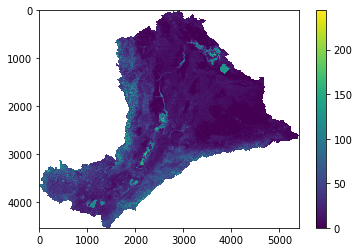

In [23]:
print(input_fhs[0])
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(input_fhs[0])
print(xsize,ysize)
SumArray=np.zeros((ysize,xsize))
for fh in month_fhs:
    Array=OpenAsArray(fh,nan_values=True)
    SumArray+=Array
plt.imshow(SumArray)
plt.colorbar()
plt.show()

In [24]:
output_folder=r'.\data\L2_AETI_M'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
out_fh=os.path.join(output_folder,'AETI_{:04d}{:02d}.tif'.format(date.year,date.month))
CreateGeoTiff(out_fh, SumArray, driver, NDV, xsize, ysize, GeoT, Projection)

In [25]:
for date in month_dates:
    month_fhs=[]
    for in_fh in input_fhs:
        raster_id=os.path.split(in_fh)[-1].split('.')[0]
        raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
        start=raster_info['start_dekad'].iloc[0]
        year=raster_info.index.values.astype(int)[0]
        month=int(start[0:2])
        if (year==date.year)&(month==date.month):
            month_fhs.append(in_fh)
    SumArray=np.zeros((ysize,xsize))
    for fh in month_fhs:
        Array=OpenAsArray(fh,nan_values=True)
        SumArray+=Array
    out_fh=os.path.join(output_folder,'AETI_{:04d}{:02d}.tif'.format(date.year,date.month))
    CreateGeoTiff(out_fh, SumArray, driver, NDV, xsize, ysize, GeoT, Projection)

## Step 4. Aggregate data in a period

First, get the list of all corrected rasters in the folder

In [26]:
input_folder=r'.\data\L2_AETI_D_corrected'
input_fhs=glob.glob(input_folder+'\*.tif')
input_fhs

['.\\data\\L2_AETI_D_corrected\\L2_AETI_0901.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0902.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0903.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1001.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1002.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1003.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1004.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1005.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1006.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1007.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1008.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1009.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1010.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1011.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1012.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1013.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1014.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1015.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1016.tif',
 '.\\data\\L2_AETI_D_corrected\

Create the period with starting and ending dates

In [27]:
start_period='2010-02-01'
end_period='2010-08-15'
period_dates=pd.date_range(start_period,end_period,freq='D')
period_dates

DatetimeIndex(['2010-02-01', '2010-02-02', '2010-02-03', '2010-02-04',
               '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08',
               '2010-02-09', '2010-02-10',
               ...
               '2010-08-06', '2010-08-07', '2010-08-08', '2010-08-09',
               '2010-08-10', '2010-08-11', '2010-08-12', '2010-08-13',
               '2010-08-14', '2010-08-15'],
              dtype='datetime64[ns]', length=196, freq='D')

Get the available raster info table.

In [28]:
df=hkv.read_wapor.get_catalogus(version='2.0')
ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2019-12-31]')
df_avail

data_avail_period: DEKAD


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L2_AETI_0901,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0111,0120,L2_AETI_0902,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0121,0131,L2_AETI_0903,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0201,0210,L2_AETI_0904,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0211,0220,L2_AETI_0905,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0221,0228,L2_AETI_0906,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0301,0310,L2_AETI_0907,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0311,0320,L2_AETI_0908,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0321,0331,L2_AETI_0909,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."


Loop over the list of rasters in the folder and check if the starting **or** ending date of raster belong to the period.
If that is true, append the raster file handle to the list **period_fhs**

In [29]:
period_fhs=[]
for in_fh in input_fhs:
    #get raster id from file name
    raster_id=os.path.split(in_fh)[-1].split('.')[0]
    #get raster info using raster id
    raster_info=df_avail.loc[df_avail['raster_id']==raster_id]    
    #get time string
    startstr=raster_info['start_dekad'].iloc[0]
    endstr=raster_info['end_dekad'].iloc[0]
    yearstr=raster_info.index[0]
    #get start and end date of raster
    raster_startdate=pd.Timestamp(int(yearstr),int(startstr[0:2]),int(startstr[2:4]),0)
    raster_enddate=pd.Timestamp(int(yearstr),int(endstr[0:2]),int(endstr[2:4]),0)
    #check if raster belong to period
    if ((raster_startdate in period_dates) or (raster_enddate in period_dates)):
        period_fhs.append(in_fh)   
period_fhs

['.\\data\\L2_AETI_D_corrected\\L2_AETI_1004.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1005.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1006.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1007.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1008.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1009.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1010.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1011.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1012.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1013.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1014.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1015.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1016.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1017.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1018.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1019.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1020.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1021.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_1022.tif',
 '.\\data\\L2_AETI_D_corrected\

Sum all raster datasets in period

In [30]:
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(period_fhs[0])
SumArray=np.zeros((ysize,xsize))
for fh in period_fhs:
    Array=OpenAsArray(fh,nan_values=True)
    SumArray+=Array
out_fh=os.path.join(f'.\data\L2_AETI_{start_period}_{end_period}.tif')
CreateGeoTiff(out_fh, SumArray, driver, NDV, xsize, ysize, GeoT, Projection)

## Step 5. Warp raster data

Spatial data come in different size, resolution, and spatial referencing system. For example, when open as array the size of Precipitation and Actual Evapotranspiration and Interception maps are different.

(90, 107)


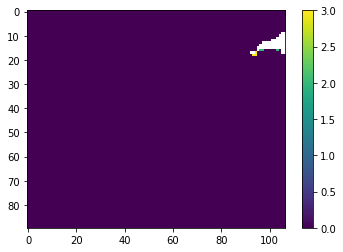

In [31]:
P_fh=r".\data\L1_PCP_E_cropped\L1_PCP_090101.tif"
P=OpenAsArray(P_fh,nan_values=True)
print(P.shape)
plt.imshow(P)
plt.colorbar()
plt.show()

(4529, 5406)


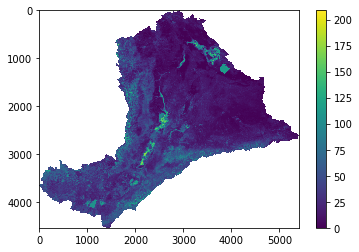

In [32]:
ET_fh=r".\data\L2_AETI_M\AETI_200901.tif"
ET=OpenAsArray(ET_fh,nan_values=True)
print(ET.shape)
plt.imshow(ET)
plt.colorbar()
plt.show()

As we can see, the precipitation data has lower resolution (0.5 degree), thus, smaller array size (90x107) than the ET data (100m and 4529x5406). To these two rasters in same calculation, they must be converted to the same size, resolution and projection. Here, we use the land-use map as the *template* to warp these data into the same form.

This can be done using the *gdal.Warp* function, an image mosaicing, reprojection and warping function. 
The *gdal.Warp* is used to warp the given raster data to pre-defined data size and spatial extent, reproject it to pre-defined spatial reference system.
To *gdal.Warp* a raster file to match projection, size, extent with another raster file, the information of the target file need to be obtained first. 
The below function is to get nodata value, spatial reference system, data size, spatial extent of a raster file using *gdal* package. 

For example, here the Landuse map raster file is the target one and we want to match projection, size, extent of the source file, which is Precipitation, with the target file.

In [33]:
src_info=gdal.Info(gdal.Open(P_fh),format='json')
dst_info=gdal.Info(gdal.Open(ET_fh),format='json')

print('Source info: ',src_info,'\n')

print('Output info: ',dst_info)

Source info:  {'description': '.\\data\\L1_PCP_E_cropped\\L1_PCP_090101.tif', 'driverShortName': 'GTiff', 'driverLongName': 'GeoTIFF', 'files': ['.\\data\\L1_PCP_E_cropped\\L1_PCP_090101.tif'], 'size': [107, 90], 'coordinateSystem': {'wkt': 'GEOGCS["WGS 84",\n    DATUM["WGS_1984",\n        SPHEROID["WGS 84",6378137,298.257223563,\n            AUTHORITY["EPSG","7030"]],\n        AUTHORITY["EPSG","6326"]],\n    PRIMEM["Greenwich",0],\n    UNIT["degree",0.0174532925199433],\n    AUTHORITY["EPSG","4326"]]'}, 'geoTransform': [37.95000000000002, 0.05, 0.0, 12.4, 0.0, -0.05], 'metadata': {'': {'AREA_OR_POINT': 'Area'}, 'IMAGE_STRUCTURE': {'INTERLEAVE': 'BAND'}}, 'cornerCoordinates': {'upperLeft': [37.95, 12.4], 'lowerLeft': [37.95, 7.9], 'lowerRight': [43.3, 7.9], 'upperRight': [43.3, 12.4], 'center': [40.625, 10.15]}, 'wgs84Extent': {'type': 'Polygon', 'coordinates': [[[37.95, 12.4], [37.95, 7.9], [43.3, 7.9], [43.3, 12.4], [37.95, 12.4]]]}, 'bands': [{'band': 1, 'block': [107, 19], 'type': 

In [34]:
source_file=P_fh
output_folder=r'.\data\L1_PCP_E_warped'
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) #get filename from source_file path
output_file=os.path.join(output_folder,filename) #create a output file path

gdal.Warp(output_file,P_fh,format='GTiff',
              srcSRS=src_info['coordinateSystem']['wkt'],
              dstSRS=dst_info['coordinateSystem']['wkt'],
              srcNodata=src_info['bands'][0]['noDataValue'],
              dstNodata=dst_info['bands'][0]['noDataValue'],
              width=dst_info['size'][0],
              height=dst_info['size'][1],
              outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                            dst_info['cornerCoordinates']['lowerLeft'][1],
                            dst_info['cornerCoordinates']['upperRight'][0],
                            dst_info['cornerCoordinates']['upperRight'][1]),
              outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
              resampleAlg='near')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000023D4F1A26F0> >

### Exercise 3
Make a user-defined function to warp any raster file with a given raster.
Use this function to match projection, size, extent of all precipitation with the ET data.

In [ ]:
def MatchProjResNDV(source_file, target_fhs, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    Matches the projection, resolution and no-data-value of a list of target-files
    with a source-file and saves the new maps in output_dir.
    
    Parameters
    ----------
    source_file : str
        The file to match the projection, resolution and ndv with.
    target_fhs : list
        The files to be reprojected.
    output_dir : str
        Folder to store the output.
    resample : str, optional
        Resampling method to use, default is 'near' (nearest neighbour).
    dtype : str, optional
        Datatype of output, default is 'float32'.
    scale : int, optional
        Multiple all maps with this value, default is None.
    
    Returns
    -------
    output_files : ndarray 
        Filehandles of the created files.
    """
    '''
    Write your code here
    '''
    return output_files

input_folder=r".\data\L1_PCP_E_cropped"
input_fhs=glob.glob(os.path.join(input_folder,'*.tif'))
output_folder=r'.\data\L1_PCP_E_warped'
MatchProjResNDV(ET_fh, input_fhs, output_folder)

## Step 6. Clip to Shapefile cutline

[**Step 1**](#1.-Crop-to-Extent) only crops a raster to a bounding box. When we need to exclude pixels outside of region of interest, for example, in case of hydrological basin or irrigation block, we can use *gdal.Warp* with cutline option to clip a raster to the polygon boundary of a shapefile. See the example below

In [38]:
input_fh=r".\data\L1_PCP_E_warped\L1_PCP_090101.tif" # path to the raster to be clipped
shp_fh=r".\data\Awash_shapefile.shp" #path to the shapefile containing polygon of region of interest

output_folder=r'.\data\L1_PCP_E_clipped'#path to output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) #get filename from source_file path
output_fh=os.path.join(output_folder,filename) #create a output file path

After defining the input and ouput raster file and the shapefile paths, we can use *ogr* library function to read shapefile dataset as gdal object to get the layer name. Then, use the shapefile path and layer as options arguments for *gdal.Warp* function.

In [39]:
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) #read shapefile as gdal dataset
inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)

Similar to [**step 5**](#5.-Warp-raster-data), we can define a new function and apply it to all the files to be clipped.

In [40]:
def CliptoShp(input_fhs,output_folder,shp_fh,NDV=-9999):
    """
    Clip raster to boundary line of a shapefile
    
    Parameters
    ----------
    input_fhs : list
        The list of input raster files
    output_folder : str
        The path to folder where to save output rasters
    shp_fh : str
        Folder to store the output.
    NDV : float or int, optional
        No Data Value of output raster
        
    Returns
    -------
    output_fhs : list 
        Filehandles of the created files.
    """
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(shp_fh, 1)
    inLayer = inDataSource.GetLayer()    
    options = gdal.WarpOptions(cutlineDSName = shp_fh,
                               cutlineLayer = inLayer.GetName(),
                               cropToCutline = True, 
                               dstNodata=NDV
                               )
    output_fhs=[]
    for input_fh in input_fhs:
        output_fh=os.path.join(output_folder,os.path.basename(input_fh))
        sourceds = gdal.Warp(output_fh, input_fh, options = options)
        output_fhs.append(output_fh)
    return output_fhs

In [42]:
input_folder=r".\data\L1_PCP_E_warped"
input_fhs=glob.glob(os.path.join(input_folder,'*.tif'))
output_folder=r'.\data\L1_PCP_E_clipped'
CliptoShp(input_fhs, output_folder,shp_fh)

['.\\data\\L1_PCP_E_clipped\\L1_PCP_090101.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090102.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090103.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090104.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090105.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090106.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090107.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090108.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090109.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090110.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090111.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090112.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090113.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090114.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090115.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090116.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090117.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090118.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090119.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090120.tif',
 '.\\data\\L1_PCP_E_